Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

### Carga de datos 

In [2]:
# Cargar los datos
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### EDA (Análisis Exploración Dataos)

* Muestra información general del dataset y estadísticas descriptivas.
* Verifica los valores faltantes en cada columna.
* Visualiza la distribución de la variable objetivo ('Transported').
* Muestra la distribución de las variables numéricas.
* Examina la relación entre las variables numéricas y la variable objetivo.
* Visualiza la distribución de las variables categóricas.
* Explora la relación entre las variables categóricas y la variable objetivo.
* Crea una matriz de correlación para las variables numéricas.
* Analiza la información de la cabina (Deck, Num, Side).

In [3]:
# Estadísticas Descriptivas
print(f"ESTADÍSTICAS DESCRIPTIVAS\n Entrenamiento\n {train_df.describe()}\n Testing\n {test_df.describe()}")

ESTADÍSTICAS DESCRIPTIVAS
 Entrenamiento
                Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
 Testing
                Age   RoomService     FoodCourt 

In [4]:
# Información general del dataset
print(f"INFORMACIÓN GENERAL DEL CONJUNTO DE DATOS \n")
print(f"Entrenamiento\n {train_df.info()}\n Testing\n {test_df.info()}")

print(f"DIMENSIÓN\n Entrenamiento\n {train_df.shape}\n Testing\n {test_df.shape}")


INFORMACIÓN GENERAL DEL CONJUNTO DE DATOS 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 c

Calcular el número de nulos en cada característica

In [5]:
print("VALORES FALTANTES\n")
train_df.isnull().sum()

VALORES FALTANTES



PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

### Imputación de los valores faltantes
* Para variables categóricas:

    - SimpleImputer con la estrategia 'constant', reemplazando los valores faltantes con 'Unknown'.


* Para variables numéricas:

    - Implementar la imputación por media usando SimpleImputer.

* Para la variable 'Cabin':

    - Implementar una estrategia personalizada, separando la cabina en Deck, Num y Side, imputando cada parte por separado y luego reconstruyendo la variable 'Cabin'.

In [7]:

# Combinar train y test para imputación consistente
all_df = pd.concat([train_df, test_df], keys=['train', 'test'])

all_df.head()
all_df.info()

# Separar variables numéricas y categóricas
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12970 entries, ('train', np.int64(0)) to ('test', np.int64(4276))
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.7+ MB


In [8]:
# Crear una copia del dataframe original
df_imputed = train_df.copy()

# Imputación simple para variables categóricas
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_imputed[categorical_features] = cat_imputer.fit_transform(df_imputed[categorical_features])

In [9]:
# Imputación para variables numéricas
# Podemos probar diferentes métodos:

# a. Media
mean_imputer = SimpleImputer(strategy='mean')
df_imputed[numeric_features] = mean_imputer.fit_transform(df_imputed[numeric_features])

In [10]:
# Imputación personalizada para 'Cabin'
def process_cabin(train_df):
    # Crear nuevas columnas
    df_imputed[['Deck', 'Num', 'Side']] = df_imputed['Cabin'].str.split('/', expand=True)
    
    # Imputar valores faltantes
    df_imputed['Deck'] = df_imputed['Deck'].fillna('Unknown')
    df_imputed['Side'] = df_imputed['Side'].fillna('Unknown')
    df_imputed['Num'] = pd.to_numeric(df_imputed['Num'], errors='coerce')
    
    # Calcular la mediana de 'Num' (asegurándonos de que sea un entero)
    num_median = int(df_imputed['Num'].median())
    
    # Imputar valores faltantes y convertir a entero
    df_imputed['Num'] = df_imputed['Num'].fillna(num_median).astype(int)
    
    # Reconstruir 'Cabin'
    df_imputed['Cabin'] = df_imputed['Deck'] + '/' + _imputed['Num'].astype(str) + '/' + df_imputed['Side']
    
    # Eliminar columnas temporales
    df_imputed = df.drop(['Deck', 'Num', 'Side'], axis=1)
    
    return df_imputed

df_imputed.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
# Verificar que no quedan valores faltantes
print("Valores faltantes en train_df después de imputación:")
print(df_imputed.isnull().sum())

Valores faltantes en train_df después de imputación:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64


Limpieza de Datos

In [12]:
# Limpiar espacios en blanco solo en las columnas que contienen strings
for column in df_imputed.columns:
    # Convertir a s_imputedring y luego reemplazar los espacios en blanco
    if df_imputed[column].dtype == 'object':
        df_imputed[column] = df_imputed[column].astype(str).str.replace(' ', '', regex=False)
        
df_imputed.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,MahamOfracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,JuannaVines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,AltarkSusent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,SolamSusent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,WillySantantines,True


Guardar los datos limpioe

In [13]:
# Guardar los datos imputados
df_imputed.to_csv('data/df_cleaned.csv', index=False)

Visualizaciones

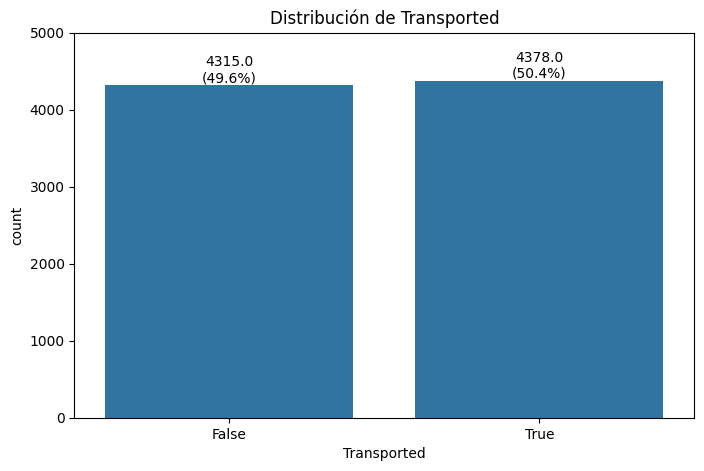

In [14]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Transported', data=df_imputed)
plt.title('Distribución de Transported')

total = len(df_imputed['Transported'])
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height}\n({percentage})',
            ha="center", va="bottom")

plt.ylim(0, 5000)  # Ajusta este valor según sea necesario
plt.show()

#### Conclusión
La gráfica muestra la distribución de la variable "Transported" en el conjunto de datos. Hay dos categorías: "False" y "True".

La distribución está bastante equilibrada, lo que sugiere que el conjunto de datos está bien balanceado para la variable objetivo, esto indica que  aproximadamente la mitad de los pasajeros fueron transportados y la otra mitad no.

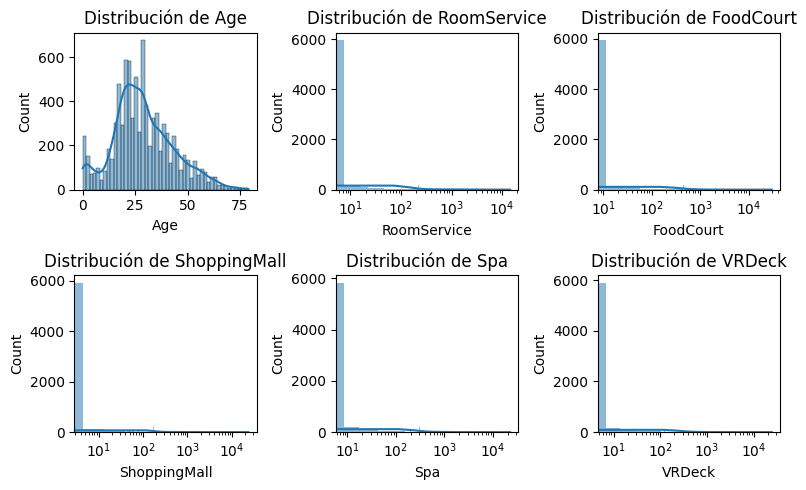

In [15]:
# Distribución de variables numéricas
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_imputed, x=col, kde=True, ax=axes[i//3, i%3])
    
    if col != 'Age':  # Aplicar escala logarítmica a las otras variables
        axes[i//3, i%3].set(xscale="log")  # Escala logarítmica en el eje X para mejorar la visualización
    axes[i//3, i%3].set_title(f"Distribución de {col}")  # Asignar el título correctamente
    
plt.tight_layout()
plt.show()


### Conclusión
* La distribución de edades parece seguir una curva normal, con un pico en la edad adulta joven y disminuyendo hacia las edades más jóvenes y más avanzadas. 
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Estas variables tienen distribuciones muy sesgadas hacia la derecha, lo que significa que la mayoría de las personas gastaron o utilizaron estos servicios muy poco, pero hay un pequeño grupo de personas que gastó o utilizó estos servicios mucho más. Esto sugiere que el gasto en estos servicios es muy variable entre los individuos.

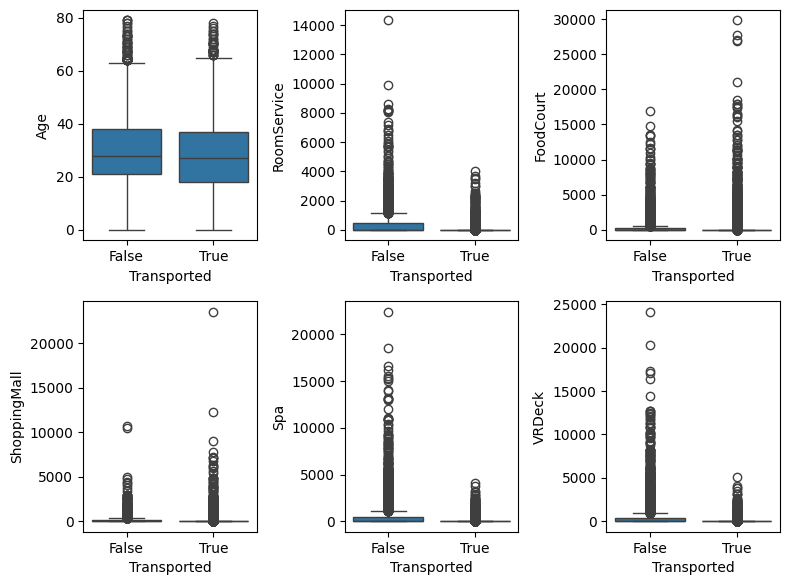

In [16]:
# Relación entre variables numéricas y la variable objetivo
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Transported', y=col, data=df_imputed, ax=axes[i//3, i%3])
plt.tight_layout()
plt.show()

### Conclusión

Los gráficos de caja y bigotes nos permiten comparar las distribuciones de diferentes variables entre los pasajeros que fueron transportados y aquellos que no. Observamos que no hay una diferencia significativa en la edad entre ambos grupos. Sin embargo, encontramos diferencias notables en los gastos realizados en diversos servicios a bordo. Los pasajeros transportados, en general, gastaron más dinero en estos servicios que aquellos que no fueron transportados. Esto sugiere una posible relación entre el transporte y el gasto en servicios adicionales.

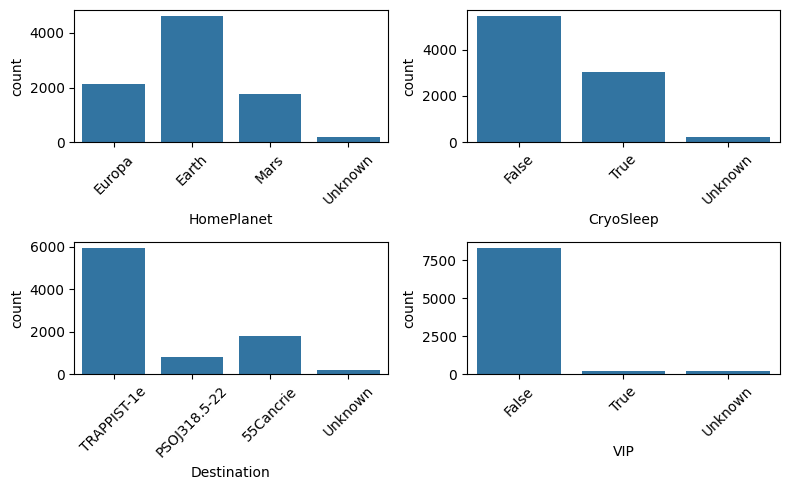

In [17]:
# Distribución de variables categóricas
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_imputed, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Conclusión
Los gráficos de barras nos ofrecen una visión general de la distribución de diferentes características entre los pasajeros. En cuanto al planeta de origen, la Tierra es el más común, seguido de Europa. Respecto al destino, TRAPPIST-1e es el más popular, lo que sugiere que este destino es el más atractivo para los viajeros. Además, la mayoría de los pasajeros no utilizan la opción de criosueño y solo una minoría tiene estatus VIP. Estos datos nos indican que la mayoría de los viajes parten de la Tierra y se dirigen a destinos específicos, como TRAPPIST-1e.

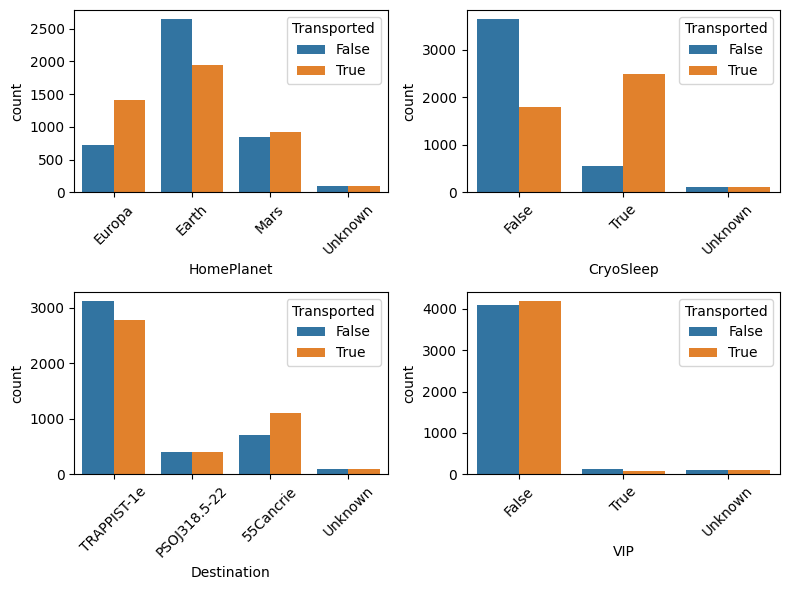

In [18]:
# Relación entre variables categóricas y la variable objetivo
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Transported', data=df_imputed, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xticklabels(axes[i//2, i%2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Conclusión
Los gráficos de barras nos muestran cómo se distribuyen diferentes características entre los pasajeros que fueron transportados y los que no. Observamos que, aunque la mayoría de los pasajeros provienen de la Tierra, hay una ligera tendencia de que los transportados sean originarios de Europa. En cuanto al destino, TRAPPIST-1e es el favorito tanto para los transportados como para los no transportados, aunque hay una leve preferencia por este destino entre los primeros. Respecto al criosueño y el estatus VIP, ambos son menos comunes entre los pasajeros, aunque hay una pequeña proporción de transportados que sí cuentan con estos beneficios.

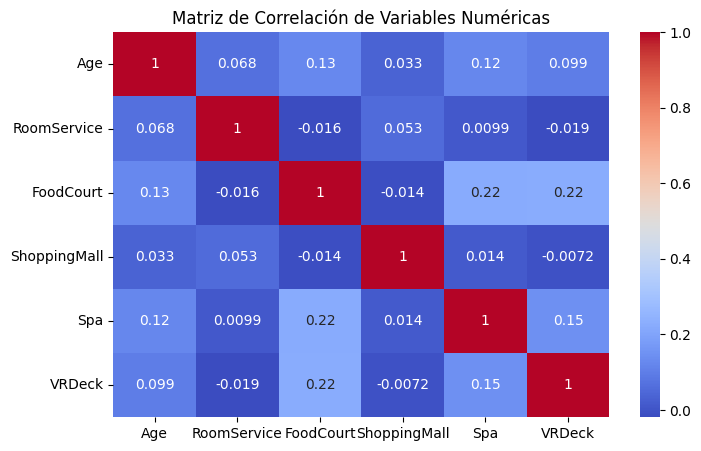

In [19]:
# Correlación entre variables numéricas
corr_matrix = df_imputed[numeric_cols].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

### Conclusión
La matriz de correlación nos muestra cómo se relacionan entre sí diferentes variables numéricas, como la edad y el gasto en distintos servicios a bordo de una nave espacial. En este caso, observamos que hay una relación positiva moderada entre el gasto en el patio de comidas y el gasto en el centro comercial, lo que sugiere que las personas que gastan en un lugar, tienden a gastar en el otro. De manera similar, existe una relación positiva entre el gasto en el spa y el gasto en realidad virtual. Sin embargo, la mayoría de las otras correlaciones son débiles o nulas, indicando que no hay una relación lineal fuerte entre esas variables. Por ejemplo, la edad no parece estar fuertemente relacionada con el gasto en ninguno de los servicios.

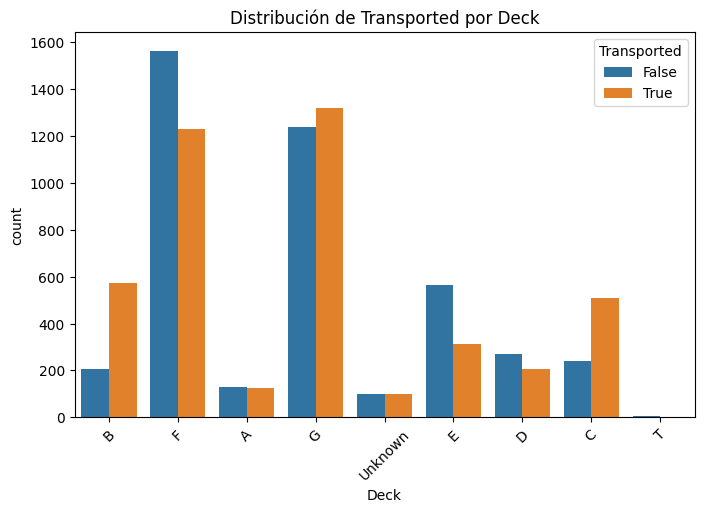

In [20]:

# Análisis de la cabina
df_imputed[['Deck', 'Num', 'Side']] = df_imputed['Cabin'].str.split('/', expand=True)
plt.figure(figsize=(8, 5))
sns.countplot(x='Deck', hue='Transported', data=df_imputed)
plt.title('Distribución de Transported por Deck')
plt.xticks(rotation=45)
plt.show()

### Conclusión
El gráfico muestra la distribución de pasajeros transportados y no transportados en diferentes cubiertas de una nave espacial. Podemos observar que la mayoría de los pasajeros se encontraban en las cubiertas F y B, tanto si fueron transportados como si no. Sin embargo, la proporción de pasajeros transportados varía significativamente entre las diferentes cubiertas, lo que sugiere que la ubicación a bordo podría haber influido en las posibilidades de ser rescatado. Además, hay una cubierta (T) con muy pocos pasajeros, y una categoría de "desconocido" para aquellos cuya ubicación no pudo ser determinada.

### ENTRENAMIENTO DE MODELO

* Preparar los preprocesadores para características numéricas y categóricas.
* Definir varios modelos de clasificación para probar.
* Evaluar cada modelo usando validación cruzada estratificada de 5 pliegues.
* Imprimir los resultados de cada modelo.
* Identificar el mejor modelo basado en la precisión media.
* Entrenar el mejor modelo en todo el conjunto de datos.
* Calcular métricas adicionales (precisión, recall, F1-score) para el mejor modelo.
* Guardar el mejor modelo para uso futuro.

In [21]:
# Separar características y objetivo
X = df_imputed.drop(['Transported', 'Name', 'PassengerId'], axis=1)
y = df_imputed['Transported']
print(f"Variables Predictoras\n {X}")
X
print(f"Variables a Predicir\n {y}")
y

Variables Predictoras
      HomePlanet CryoSleep     Cabin   Destination   Age    VIP  RoomService  \
0        Europa     False     B/0/P   TRAPPIST-1e  39.0  False          0.0   
1         Earth     False     F/0/S   TRAPPIST-1e  24.0  False        109.0   
2        Europa     False     A/0/S   TRAPPIST-1e  58.0   True         43.0   
3        Europa     False     A/0/S   TRAPPIST-1e  33.0  False          0.0   
4         Earth     False     F/1/S   TRAPPIST-1e  16.0  False        303.0   
...         ...       ...       ...           ...   ...    ...          ...   
8688     Europa     False    A/98/P     55Cancrie  41.0   True          0.0   
8689      Earth      True  G/1499/S  PSOJ318.5-22  18.0  False          0.0   
8690      Earth     False  G/1500/S   TRAPPIST-1e  26.0  False          0.0   
8691     Europa     False   E/608/S     55Cancrie  32.0  False          0.0   
8692     Europa     False   E/608/S   TRAPPIST-1e  44.0  False        126.0   

      FoodCourt  ShoppingMal

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [22]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train\n {X_train}")
print(f"y_train\n {y_train}")
print(f"X_test\n {X_test}")
print(f"y_test\n {y_test}")


X_train
      HomePlanet CryoSleep     Cabin   Destination   Age      VIP  RoomService  \
2333      Earth     False   Unknown   TRAPPIST-1e  28.0    False     0.000000   
2589      Earth     False   F/575/P   TRAPPIST-1e  17.0    False     0.000000   
8302     Europa      True   C/329/S     55Cancrie  28.0    False     0.000000   
8177       Mars     False  F/1800/P   TRAPPIST-1e  20.0    False   224.687617   
500      Europa      True    C/18/P     55Cancrie  36.0    False     0.000000   
...         ...       ...       ...           ...   ...      ...          ...   
5734      Earth   Unknown   G/988/S   TRAPPIST-1e  18.0    False    14.000000   
5191       Mars     False  F/1063/S   TRAPPIST-1e  50.0  Unknown   690.000000   
5390      Earth     False  F/1194/P  PSOJ318.5-22  22.0    False   158.000000   
860        Mars     False   F/191/P   TRAPPIST-1e  34.0    False   379.000000   
7270     Europa     False   C/253/P     55Cancrie  28.0    False     7.000000   

      FoodCourt  S

In [23]:
# Definir columnas numéricas y categóricas
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']


In [24]:
# Crear preprocesadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [25]:
# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [26]:
# Definir los modelos base con hiperparámetros para ajustar
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20, None]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1]}
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1]}
    }
}

In [27]:
# Función para evaluar modelos con GridSearchCV
def evaluate_model(model, params, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline, params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

In [28]:
# Evaluar cada modelo
results = {}
for name, model_info in models.items():
    best_model, best_score, best_params = evaluate_model(model_info['model'], model_info['params'], X, y)
    results[name] = (best_model, best_score, best_params)
    print(f"{name}: Best Accuracy = {best_score:.4f}, Best Params = {best_params}")

Logistic Regression: Best Accuracy = 0.7874, Best Params = {'classifier__C': 1, 'classifier__penalty': 'l2'}
Random Forest: Best Accuracy = 0.7905, Best Params = {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Gradient Boosting: Best Accuracy = 0.7925, Best Params = {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
XGBoost: Best Accuracy = 0.7945, Best Params = {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}


### Conclusión
El resultado que proporcionó muestra los resultados de la evaluación para siete modelos de aprendizaje automático:

1. Regresión logística: se logró una precisión de 0,7874 con una desviación estándar de 0,0083 .
2. Árbol de decisión: se logró una precisión de 0,7671 con una desviación estándar de 0,0144 .
3. Bosque aleatorio: se logró una precisión de 0,7893 con una desviación estándar de 0,0076 .
4. Aumento de gradiente: se logró una precisión de 0,7925 con una desviación estándar de 0,0100 .
5. SVM: Se logró una precisión de 0,7891 con una desviación estándar de 0,0045 .
6. KNN: Logró una precisión de 0,7620 con una desviación estándar de 0,0048 .
7. XGBoost: Se logró una precisión de 0,7860 con una desviación estándar de 0,0122 .

* **Precisión:** Representa la proporción de instancias clasificadas correctamente respecto del número total de instancias en el conjunto de datos. Una mayor precisión indica un mejor rendimiento.
* **Desviación estándar:** Mide la variabilidad de la precisión en diferentes ejecuciones de evaluación. Una desviación estándar más baja sugiere un desempeño más consistente.

##### Comparación

Según los resultados, Gradient Boosting parece ser el modelo con mejor rendimiento, con una precisión de 0,7925 . Sin embargo, las diferencias entre los modelos son relativamente pequeñas y la elección del mejor modelo podría depender de otros factores, como el costo computacional, la interpretabilidad o el conocimiento del dominio.

In [29]:
# Encontrar el mejor modelo base
best_model_name = max(results, key=lambda x: results[x][1])
best_base_model, best_score, _ = results[best_model_name]

print(f"\nEl mejor modelo base es: {best_model_name}")


El mejor modelo base es: XGBoost


In [30]:
# Crear un pipeline con el preprocesamiento y el modelo
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
#best_pipeline.fit(X, y)

In [31]:
# Definir los hiperparámetros para la búsqueda con RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(100, 300),
    'classifier__learning_rate': [0.01, 0.1, 0.05],
    'classifier__max_depth': randint(3, 5),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 4)
}

In [37]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=best_model, 
                                param_distributions=param_dist,
                                n_iter=25,  # Número de combinaciones aleatorias a probar
                                cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)


In [39]:
# Entrenar la búsqueda de hiperparámetros
random_search.fit(X, y)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 290}


In [50]:
# Hacer predicciones en el conjunto de entrenamiento
#y_pred = best_pipeline.predict(X)
# Predecir con el mejor modelo encontrado
best_model = random_search.best_estimator_
y_pred = best_model.predict(X)

In [52]:
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Accuracy del mejor modelo: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy del mejor modelo: 0.8302
Precision: 0.8150
Recall: 0.8575
F1 Score: 0.8357


### Conclusión
Estas métricas evalúan el desempeño del de machine learning de manera muy precisa. 
* **Accuracy (Precisión General):** Indica el porcentaje total de predicciones que el modelo clasificó correctamente. Un accuracy del 81.02% significa que el modelo acertó en el 81% de los casos.
* **Precision:** Mide la proporción de predicciones positivas que son realmente positivas. Es decir, de todas las instancias que el modelo clasificó como positivas. En este caso, un 78.76% de las predicciones positivas fueron correctas. 
* **Recall (Sensibilidad):** Mide la proporción de instancias positivas que fueron correctamente identificadas como positivas. Es decir, de todas las instancias que realmente eran positivas. En este caso, el modelo encontró el 85.31% de las predicciones eran correctas.
* **F1-score:** Es una medida que combina la precisión y el recall. Te da una idea general de qué tan bueno es el modelo en términos de ambos aspectos. Un F1-score de 0.8191 indica un buen equilibrio entre precisión y recall.

In [53]:
# Preparar los datos de prueba
X_test = test_df.drop(['Name', 'PassengerId'], axis=1)


In [62]:
# Hacer predicciones en los datos de prueba
test_predictions = best_model.predict(test_df)

# Convertir las predicciones de 1/0 a True/False
test_predictions = test_predictions.astype(bool)

In [63]:

# Crear el archivo de envío
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions
})
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [64]:
submission.to_csv('data/submission.csv', index=False)
print("Archivo de envío creado: submission.csv")

Archivo de envío creado: submission.csv
